In [69]:
from segment_anything import sam_model_registry, SamPredictor

import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from pathlib import Path


In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [3]:
sam = sam_model_registry['vit_b'](checkpoint='./weights/sam_vit_b_01ec64.pth')

device = 'cuda' # cpu

sam.to(device=device)

predictor = SamPredictor(sam)

In [72]:
path_to_buble = Path('/mnt/c/Users/egorn/Desktop/dataset/new_vids/original/1.13_frame_72_crop.png')


image = Image.open(path_to_buble).convert('RGB')

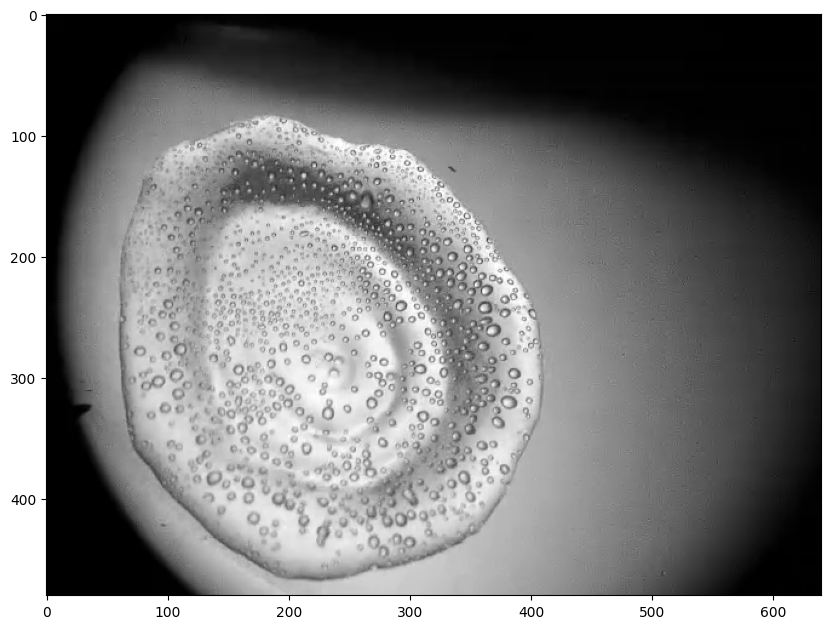

In [42]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

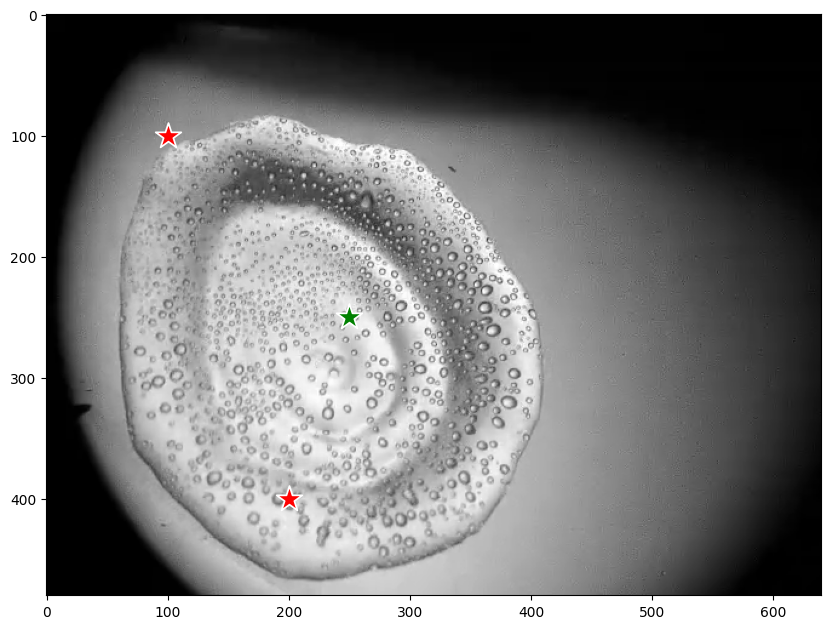

In [64]:
# точки для сегментирования

input_point = np.array([[250, 250], [100, 100], [200, 400]])
input_label = np.array([1, 0, 0])

plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

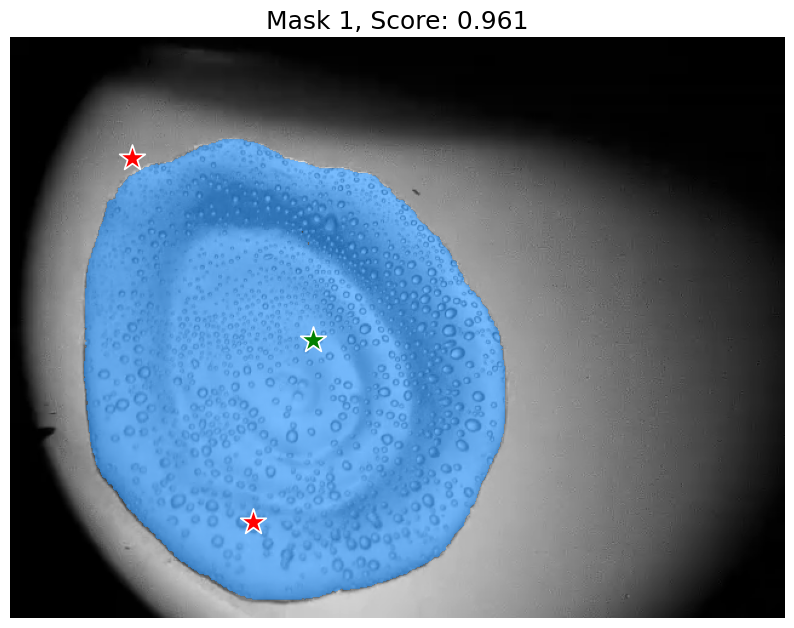

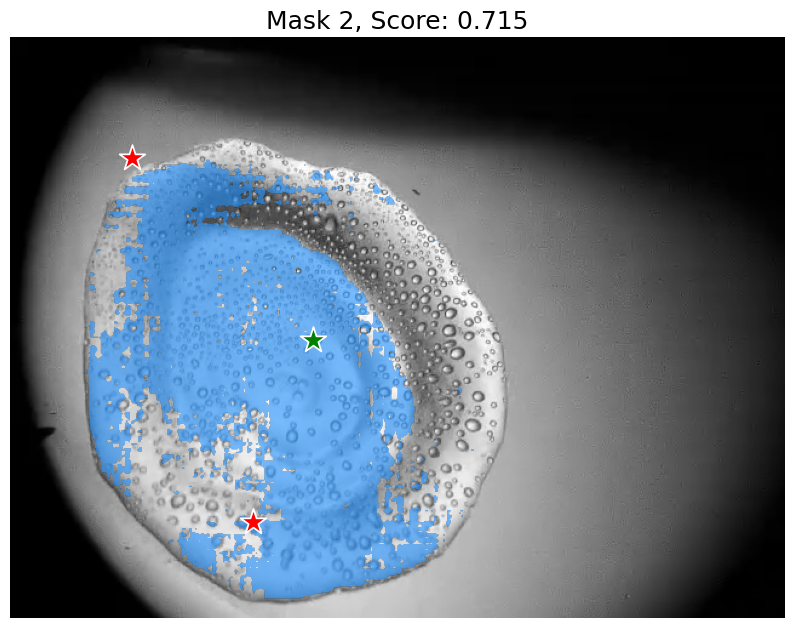

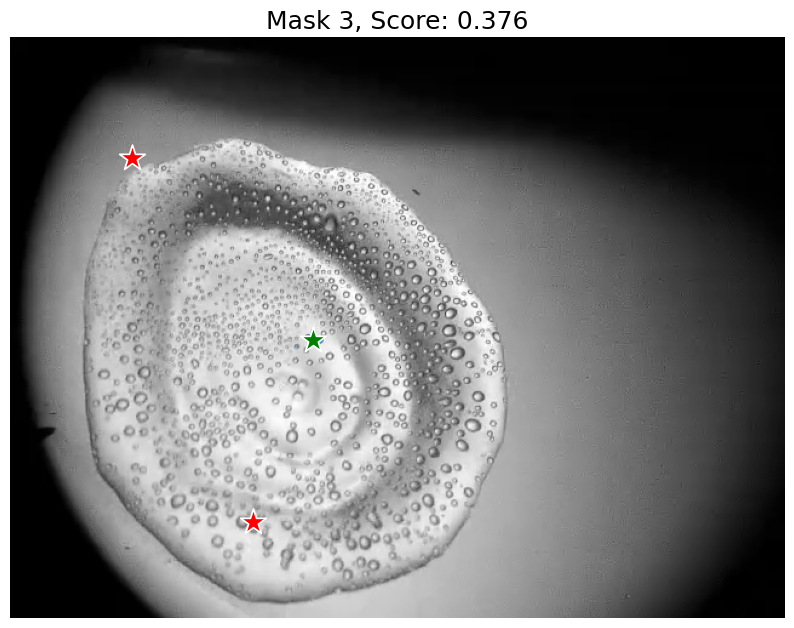

In [65]:
predictor.set_image(np.asarray(image))

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

In [56]:
new_mask = np.zeros((480, 640, 3), dtype=np.uint8)
# выбираем исходя из результатов сверху
new_mask[..., 0] = masks[1] # RED - вся капля
new_mask[..., 1] = masks[2] # GREEN (при совмещении с красным будет желтым) внутренность капли
# new_mask[..., 2] = masks[3] # BLUE (при совмещении с красным и желтым - чисто белый) рз


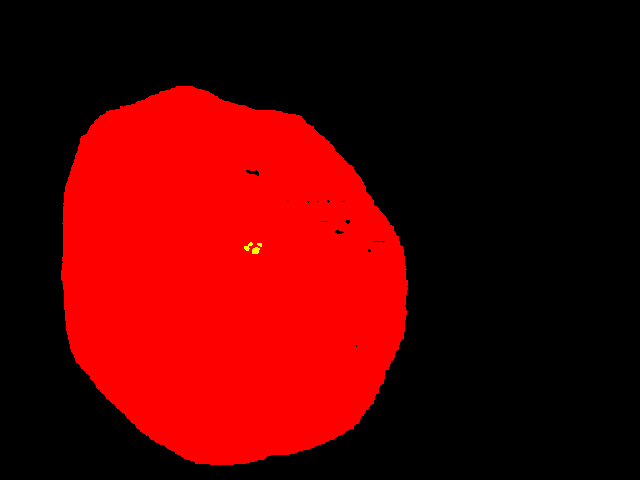

In [68]:
result = Image.fromarray(new_mask * 255)
result

In [ ]:
# сохраняем

result.save(f'./saved_pics/{path_to_buble.stem.split('_crop')[0] + '_fullmask'}')

In [73]:
path_to_buble.stem

'1.13_frame_72_crop'